In [1]:
# Discard the output of this cell.
#%%capture

# Install the required libraries.
#!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
#!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [2]:
#!pip install tensorflow-addons

In [1]:
import torch

C:\Users\avinash.rabhadia\Anaconda3\envs\GPU\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())

True


In [3]:
print(torch.cuda.device(0))

In [4]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3060


In [5]:
# Import the required libraries.
import os
import cv2
#import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import keras
#from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.utils import plot_model


from tensorflow.keras.regularizers import l2

In [6]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [7]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [8]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
print(physical_devices)


Num GPUs: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

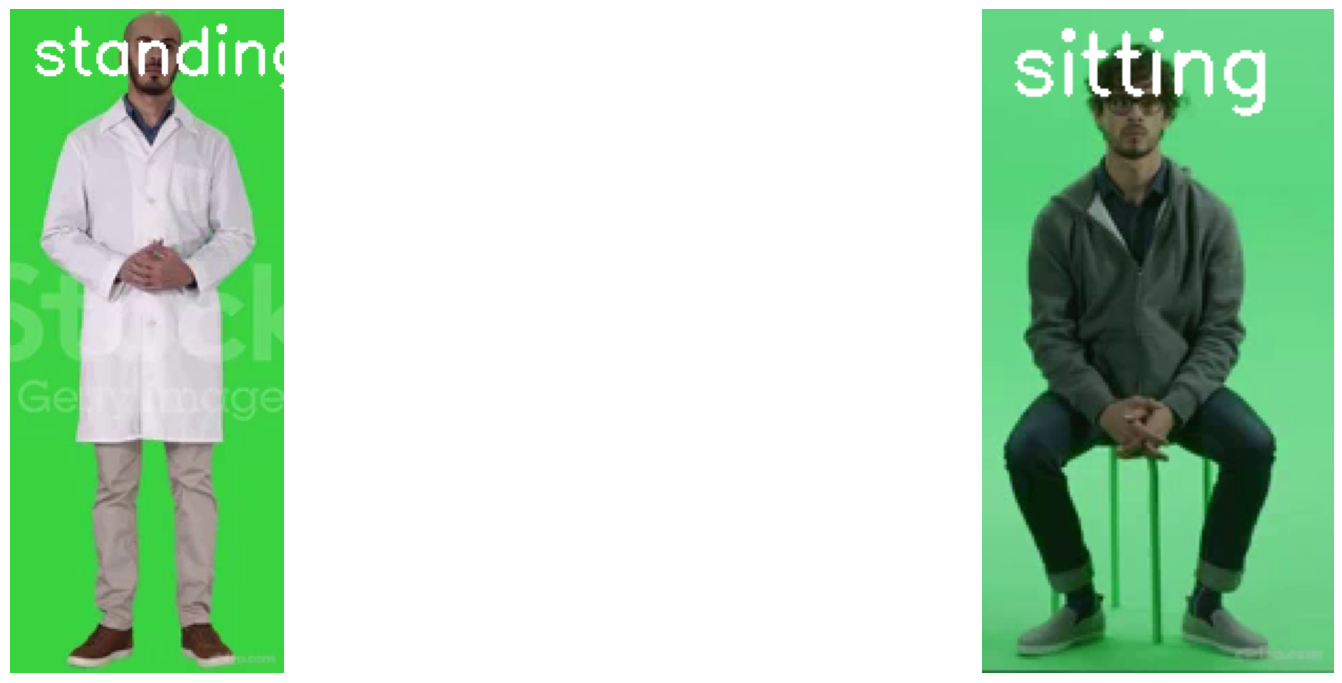

In [11]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (50, 50))



# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('D:/SittingStandingDataset2023')

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
#random_range = random.sample(range(len(all_classes_names)), 20)
random_range = random.sample(range(len(all_classes_names)), 2)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'D:/SittingStandingDataset2023/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'D:/SittingStandingDataset2023/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [12]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "D:/SittingStandingDataset2023"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Sitting","Standing"]

In [13]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [14]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [15]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Sitting
Extracting Data of Class: Standing


In [16]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [17]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [20]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((2, 2)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu',bias_regularizer=l2(0.01), kernel_regularizer = l2(0.01))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu',bias_regularizer=l2(0.01), kernel_regularizer = l2(0.01))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu',bias_regularizer=l2(0.01), kernel_regularizer = l2(0.01))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
#     model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same',activation = 'relu',bias_regularizer=l2(0.01), kernel_regularizer = l2(0.01))))
#     model.add(TimeDistributed(MaxPooling2D((1, 1))))
#     model.add(TimeDistributed(Dropout(0.25)))
    
#     model.add(TimeDistributed(Conv2D(512, (3, 3), padding='same',activation = 'relu',bias_regularizer=l2(0.001), kernel_regularizer = l2(0.001))))
#     model.add(TimeDistributed(MaxPooling2D((1, 1))))
#     model.add(TimeDistributed(Dropout(0.25)))
    
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    #model.add(LSTM(1500))
    model.add(LSTM(1000))
    #model.add(LSTM(256))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [21]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 20, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 32, 32, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 16, 16, 32)  

In [22]:
BATCH_SIZE = 32


In [23]:
# Create an Instance of Early Stopping Callback.
#opt = keras.optimizers.Adam(learning_rate=0.001)
#opt = keras.optimizers.RMSprop(learning_rate=0.01)
opt = keras.optimizers.SGD(learning_rate = 0.001,momentum = 0.99)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20 , mode = 'min', restore_best_weights = True, min_delta=0,verbose=2)

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=10,
    verbose=2,
)
model_file_name = "LRCN_model_Sitting_Standing_New_Dataset_2023.h5"
min_loss_callback = ModelCheckpoint(
    model_file_name,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=2,
)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 300,batch_size = BATCH_SIZE, 
                                             shuffle = False, validation_split = 0.25, callbacks = [early_stopping_callback,lr_callback,min_loss_callback])


# LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 300,batch_size = BATCH_SIZE, 
#                                              shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])



Epoch 1/300
31/31 [==============================] - ETA: 0s - loss: 2.1800 - accuracy: 0.4903
Epoch 1: val_loss improved from inf to 2.15460, saving model to LRCN_model_Sitting_Standing_New_Dataset_2023.h5
31/31 [==============================] - 14s 150ms/step - loss: 2.1800 - accuracy: 0.4903 - val_loss: 2.1546 - val_accuracy: 0.5092 - lr: 0.0010
Epoch 2/300
31/31 [==============================] - ETA: 0s - loss: 2.1108 - accuracy: 0.5959
Epoch 2: val_loss improved from 2.15460 to 2.06773, saving model to LRCN_model_Sitting_Standing_New_Dataset_2023.h5
31/31 [==============================] - 3s 90ms/step - loss: 2.1108 - accuracy: 0.5959 - val_loss: 2.0677 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 3/300
30/31 [============================>.] - ETA: 0s - loss: 1.9890 - accuracy: 0.6885
Epoch 3: val_loss improved from 2.06773 to 1.92735, saving model to LRCN_model_Sitting_Standing_New_Dataset_2023.h5
31/31 [==============================] - 3s 89ms/step - loss: 1.9871 - accuracy: 0.

30/31 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9469
Epoch 24: val_loss improved from 0.35360 to 0.33679, saving model to LRCN_model_Sitting_Standing_New_Dataset_2023.h5
31/31 [==============================] - 3s 89ms/step - loss: 0.2526 - accuracy: 0.9467 - val_loss: 0.3368 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 25/300
30/31 [============================>.] - ETA: 0s - loss: 0.2353 - accuracy: 0.9469
Epoch 25: val_loss improved from 0.33679 to 0.32860, saving model to LRCN_model_Sitting_Standing_New_Dataset_2023.h5
31/31 [==============================] - 3s 96ms/step - loss: 0.2346 - accuracy: 0.9467 - val_loss: 0.3286 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 26/300
30/31 [============================>.] - ETA: 0s - loss: 0.2303 - accuracy: 0.9458
Epoch 26: val_loss improved from 0.32860 to 0.30129, saving model to LRCN_model_Sitting_Standing_New_Dataset_2023.h5
31/31 [==============================] - 3s 91ms/step - loss: 0.2299 - accuracy: 0.9456 

Epoch 51/300
30/31 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9625
Epoch 51: val_loss did not improve from 0.22914
31/31 [==============================] - 2s 73ms/step - loss: 0.1437 - accuracy: 0.9621 - val_loss: 0.2825 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 52/300
30/31 [============================>.] - ETA: 0s - loss: 0.1376 - accuracy: 0.9594
Epoch 52: val_loss did not improve from 0.22914
31/31 [==============================] - 2s 73ms/step - loss: 0.1374 - accuracy: 0.9590 - val_loss: 0.2588 - val_accuracy: 0.9356 - lr: 0.0010
Epoch 53/300
30/31 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9531
Epoch 53: val_loss did not improve from 0.22914
31/31 [==============================] - 2s 73ms/step - loss: 0.1708 - accuracy: 0.9538 - val_loss: 0.2800 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 54/300
30/31 [============================>.] - ETA: 0s - loss: 0.2021 - accuracy: 0.9479
Epoch 54: ReduceLROnPlateau reducing learni

In [24]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

14/14 [==============================] - 1s 36ms/step - loss: 0.2446 - accuracy: 0.9332


In [25]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

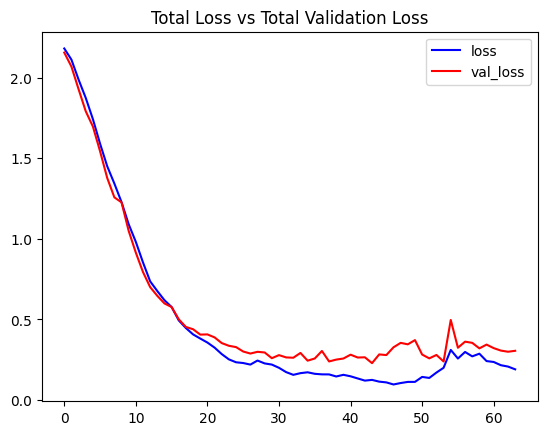

In [26]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

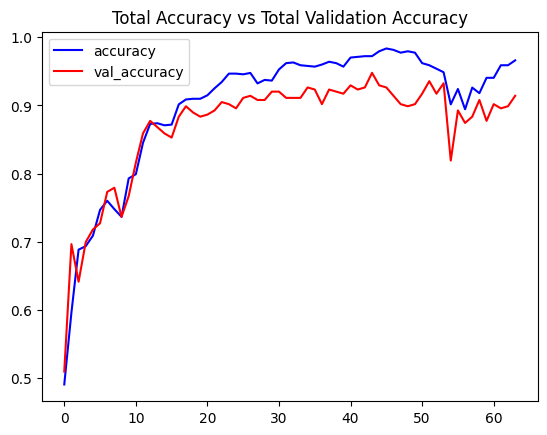

In [27]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [28]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
#model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

#model_file_name = "LRCN_model.h5"
model_file_name = "LRCN_model_Sitting_Standing_New_Dataset_2023.h5"
#model_file_name = "LRCN_model_3.h5"



# Save the Model.
LRCN_model.save(model_file_name)